In [1]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import pickle

from gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from layers import *
from rnn1 import *
from solver import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
raw = pickle.load(open("stories.pck", "rb"))
print len(raw), "examples"
print max([len(x) for x in raw]), "supporting facts and questions at most"
print max([len(y.split(' ')) for y in x for x in raw]), "words per sentence at most"

_null, _start, _query, _end = "<NULL>", "<Start>", "<Query>", "<End>"

words = [_null, _start, _query, _end] + [q for ex in raw for sent in ex for w in sent.split(' ') for q in w.split(',')]
words = sorted(set(words))
word_to_idx = {w:i for i,w in enumerate(words)}

T = 128 # longest story, 64 words unfolding
T2= 7

data = []
for ex in raw:
    sLen = 0
    while ex[sLen].find(',')==-1:
        sLen+=1
    supports = word_to_idx[_null] * np.ones(T, dtype=int)
    queries = word_to_idx[_null] * np.ones((len(ex)-sLen, T2), dtype=int)
    
    pos=0
    for idx, sent in enumerate(ex):
        if idx<sLen:
            sent = [word_to_idx[_start]] + [word_to_idx[x] for x in sent.split(' ')]
            supports[pos:pos+len(sent)+1] = sent + [word_to_idx[_end]]
            pos += len(sent)
        else:
            sent = sent.split(',')[0]
            sent = [word_to_idx[_query]] + [word_to_idx[x] for x in sent.split(' ')]
            sent = sent + [word_to_idx[_null]]*(T2-len(sent)-1) + [word_to_idx[_end]]#null pad the sentence
            queries[idx-sLen, :] = sent
    
    answers = np.asarray([word_to_idx[x.split(',')[1]] for x in ex[sLen:]]).reshape(len(ex)-sLen, 1)
    for i in xrange(queries.shape[0]):
        data.append(np.hstack((supports, queries[i,:], answers[i,:])))

data = np.asarray(data)
data_train = data[:1000,:]
data_test = data[-1000:,:]

1000 examples
27 supporting facts and questions at most
7 words per sentence at most


(Iteration 1 / 150) loss: 4.514428
(Iteration 11 / 150) loss: 3.038363
(Iteration 21 / 150) loss: 2.745959
(Iteration 31 / 150) loss: 2.882704
(Iteration 41 / 150) loss: 1.732899
(Iteration 51 / 150) loss: 1.194422
(Iteration 61 / 150) loss: 0.739283
(Iteration 71 / 150) loss: 0.577273
(Iteration 81 / 150) loss: 0.918477
(Iteration 91 / 150) loss: 0.772856
(Iteration 101 / 150) loss: 0.594255
(Iteration 111 / 150) loss: 0.342356
(Iteration 121 / 150) loss: 0.525335
(Iteration 131 / 150) loss: 0.561485
(Iteration 141 / 150) loss: 0.711433


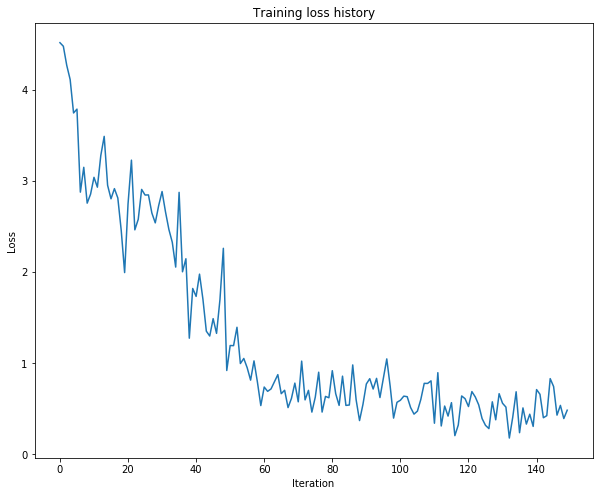

In [3]:
model = SeqNN(word_to_idx, cell_type='rnn', hidden_dim=512, wordvec_dim=512)
solver = SeqNNSolver(model, data_train[:50],
           update_rule='adam',
           num_epochs=75,
           batch_size=25,
           optim_config={
             'learning_rate': 1e-3,
           },
           lr_decay=.995,
           verbose=True, print_every=10,
         )
solver.train()

# Plot the training losses
plt.plot(solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [4]:
minibatch = data_train[:50]
print "Train:",
answ=model.loss(minibatch, sample=True)
print (answ==minibatch[:,-1]).mean()

print "\n".join(" ".join([words[x] for x in data_train[0,:-T2-1]]).split(_start))
i=0
while np.all(data_train[0,:-T2-1]==data_train[i,:-T2-1]):
  print " ".join([words[x] for x in data_train[i,-T2-1:]])
  i=i+1

print
print "Other answers:"
print "\n".join([words[x]+" "+words[y] for x,y in zip(model.loss(minibatch, sample=True), minibatch[:,-1])])

Train: 0.76

 namik vazo 'yi park 'dan aldi . <End> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL>
<Query> namik nerede ? <NULL> <NULL> <End> park
<Query> vazo nerede ? <NULL> <NULL> <End> park

Other answers:
serv

In [ ]:
model = SeqNN(word_to_idx, cell_type='rnn', hidden_dim=512, wordvec_dim=512)
solver = SeqNNSolver(model, data_train,
           update_rule='adam',
           num_epochs=100,
           batch_size=50,
           optim_config={
             'learning_rate': 1e-4,
           },
           lr_decay=.995,
           verbose=True, print_every=10,
         )
solver.train()

# Plot the training losses
plt.plot(solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

(Iteration 1 / 2000) loss: 4.486790
(Iteration 11 / 2000) loss: 4.031883
(Iteration 21 / 2000) loss: 3.626937
(Iteration 31 / 2000) loss: 3.380693
(Iteration 41 / 2000) loss: 3.289801
(Iteration 51 / 2000) loss: 3.346352
(Iteration 61 / 2000) loss: 3.424254
(Iteration 71 / 2000) loss: 3.209152
(Iteration 81 / 2000) loss: 3.292662
(Iteration 91 / 2000) loss: 3.314274
(Iteration 101 / 2000) loss: 3.305239
(Iteration 111 / 2000) loss: 3.325402


In [6]:
print "Train:",
answ=model.loss(data_train[:1000,:], sample=True)
print (answ==data_train[:1000,-1]).mean()
minibatch = data_train[:10]
print "\n".join([words[x]+" "+words[y] for x,y in zip(model.loss(minibatch, sample=True), minibatch[:,-1])])

print
print "Test:",
answ=model.loss(data_test[:1000], sample=True)
print (answ==data_test[:1000,-1]).mean()
minibatch = data_test[:10]
print "\n".join([words[x]+" "+words[y] for x,y in zip(model.loss(minibatch, sample=True), minibatch[:,-1])])

Train: 0.139
sehpa park
bahce park
okul kantin
park servis
dolap kantin
tuvalet masa
okul park
bahce park
sehpa servis
tershane servis

Test: 0.039
park masa
banyo servis
dolap park
sinif araba
sehpa bolum
banyo araba
dolap araba
banyo kantin
sinif duvar
banyo dersane
